### Classify That Penguin! 

The aim of this notebook is to conduct an exploratory data analysis (EDA) on the dataset obtained from the research article titled "Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis)" by Gorman KB, Williams TD, and Fraser WR (2014), published in PLoS ONE 9(3): e90081. Following that, data preprocessing was carried out, focusing on feature engineering of selected variables using the ANOVA F-ratio. Subsequently, dimensionality reduction was performed using principal component analysis (PCA) to reduce the number of features in the dataset. Finally, support vector machines (SVM) were employed with hyperparameter tuning using grid and randomized search techniques to build the most accurate models.

**1. The following libraries will be primarily used for loading the data, data cleaning, and conducting exploratory data analysis (EDA):**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Plotting Functions
import matplotlib.pyplot as plt

#Aesthetics
import seaborn as sns
sns.set_style('ticks')

**Loading the Data**

In [3]:
lter=pd.read_csv('penguins_lter.csv')
size=pd.read_csv('penguins_size.csv')

In [10]:
lter.info()
print('-'*30)
size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

**Here is the meaning of each feature in the dataset:**

- species: Penguin species (Chinstrap, Adélie, or Gentoo)
- culmen_length_mm: Culmen length (mm)
- culmen_depth_mm: Culmen depth (mm)
- flipper_length_mm: Flipper length (mm)
- body_mass_g: Body mass (g)
- island: Island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
- sex: Penguin gender
- Delta 15 N (o/oo): Ratio of isotope (15N)
- Delta 13 C (o/oo): Ratio of isotope (13C)

Printing the column names and categorical classifiers allows for easy copying and pasting of the code. It also helps ensure that there are no extra spaces or typos in the column names when writing the code later. Displaying the first few rows of the dataframe provides a quick preview of the data, allowing you to get an initial understanding of the dataset.

In [11]:
print(lter.columns)
print(lter['Species'].unique())
lter.head()

Index(['studyName', 'Sample Number', 'Species', 'Region', 'Island', 'Stage',
       'Individual ID', 'Clutch Completion', 'Date Egg', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments'],
      dtype='object')
['Adelie Penguin (Pygoscelis adeliae)'
 'Chinstrap penguin (Pygoscelis antarctica)'
 'Gentoo penguin (Pygoscelis papua)']


,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


**Cleaning the data**

In [12]:
new_lter=lter.copy()

new_lter['Species']=new_lter['Species'].replace({'Adelie Penguin (Pygoscelis adeliae)':'P.adeliae',
                                                 'Chinstrap penguin (Pygoscelis antarctica)':'P.antartica',
                                               'Gentoo penguin (Pygoscelis papua)':'P.papua'}) # Abbreviating the names

new_lter['Sex'].fillna('.', inplace=True)#First replace the null value with a '.' as part of that column contains them already
new_lter['Sex']=new_lter['Sex'].replace({'MALE':'male','FEMALE':'female'})#replacing uppercases with lower cases
new_lter['Sex']=new_lter['Sex'].replace({'.':new_lter['Sex'].mode()[0]})#By running this a second time with the space, it will take the mode of sex

new_lter['Culmen Length (mm)'].fillna(new_lter.groupby('Species')['Culmen Length (mm)'].transform('mean'),inplace=True)

new_lter['Culmen Depth (mm)'].fillna(new_lter.groupby('Species')['Culmen Depth (mm)'].transform('mean'),inplace=True)

new_lter['Flipper Length (mm)'].fillna(new_lter.groupby('Species')['Flipper Length (mm)'].transform('mean'),inplace=True)

new_lter['Body Mass (g)'].fillna(new_lter.groupby('Species')['Body Mass (g)'].transform('mean'),inplace=True)

new_lter['Delta 15 N (o/oo)'].fillna(new_lter.groupby('Species')['Delta 15 N (o/oo)'].transform('mean'),inplace=True)

new_lter['Delta 13 C (o/oo)'].fillna(new_lter.groupby('Species')['Delta 13 C (o/oo)'].transform('mean'),inplace=True)

new_lter['Body Mass (kg)']=new_lter['Body Mass (g)']/1000 #Conversion to kilograms

new_lter=new_lter.drop(['Body Mass (g)','studyName','Sample Number','Comments','Individual ID'], axis=1)
#We will not need these columns as they will not contribute to classification.

print(new_lter.info())#Lets check to make sure all NaN is gone
new_lter.head()#Visualize the table to confirm the changes we wanted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              344 non-null    object 
 1   Region               344 non-null    object 
 2   Island               344 non-null    object 
 3   Stage                344 non-null    object 
 4   Clutch Completion    344 non-null    object 
 5   Date Egg             344 non-null    object 
 6   Culmen Length (mm)   344 non-null    float64
 7   Culmen Depth (mm)    344 non-null    float64
 8   Flipper Length (mm)  344 non-null    float64
 9   Sex                  344 non-null    object 
 10  Delta 15 N (o/oo)    344 non-null    float64
 11  Delta 13 C (o/oo)    344 non-null    float64
 12  Body Mass (kg)       344 non-null    float64
dtypes: float64(6), object(7)
memory usage: 35.1+ KB
None


,Species,Region,Island,Stage,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (kg)
0,P.adeliae,Anvers,Torgersen,"Adult, 1 Egg Stage",Yes,11/11/07,39.100000,18.700000,181.000000,male,8.859733,-25.804194,3.750000
1,P.adeliae,Anvers,Torgersen,"Adult, 1 Egg Stage",Yes,11/11/07,39.500000,17.400000,186.000000,female,8.949560,-24.694540,3.800000
2,P.adeliae,Anvers,Torgersen,"Adult, 1 Egg Stage",Yes,11/16/07,40.300000,18.000000,195.000000,female,8.368210,-25.333020,3.250000
3,P.adeliae,Anvers,Torgersen,"Adult, 1 Egg Stage",Yes,11/16/07,38.791391,18.346358,189.953642,male,8.859733,-25.804194,3.700662
4,P.adeliae,Anvers,Torgersen,"Adult, 1 Egg Stage",Yes,11/16/07,36.700000,19.300000,193.000000,female,8.766510,-25.324260,3.450000


In [13]:
#Categorical Values
print('Region', new_lter['Region'].unique())
print('Island', new_lter['Island'].unique())
print('Stage', new_lter['Stage'].unique())
print('Clutch', new_lter['Clutch Completion'].unique())

Region ['Anvers']
Island ['Torgersen' 'Biscoe' 'Dream']
Stage ['Adult, 1 Egg Stage']
Clutch ['Yes' 'No']


In [14]:
new_lter=new_lter.drop(['Region', 'Stage', 'Date Egg'], axis=1)
new_lter.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (kg)
0,P.adeliae,Torgersen,Yes,39.100000,18.700000,181.000000,male,8.859733,-25.804194,3.750000
1,P.adeliae,Torgersen,Yes,39.500000,17.400000,186.000000,female,8.949560,-24.694540,3.800000
2,P.adeliae,Torgersen,Yes,40.300000,18.000000,195.000000,female,8.368210,-25.333020,3.250000
3,P.adeliae,Torgersen,Yes,38.791391,18.346358,189.953642,male,8.859733,-25.804194,3.700662
4,P.adeliae,Torgersen,Yes,36.700000,19.300000,193.000000,female,8.766510,-25.324260,3.450000


Before constructing a model, it is essential to explore the data to identify meaningful relationships. Through initial exploration, we can draw conclusions about the potential significance of certain features. To begin, we will calculate the total count of species categorized by sex.

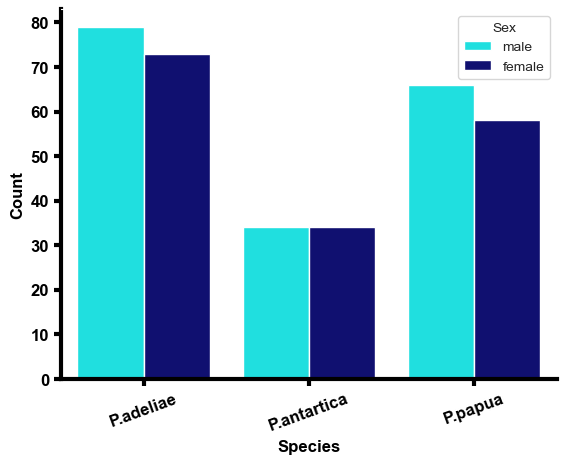

In [18]:
fig, ax = plt.subplots()
sns.countplot(data=new_lter, x='Species', hue='Sex', palette=['cyan', 'navy'])

ax.tick_params(direction='out', length=5, width=3, colors='k',
grid_color='k', grid_alpha=1, grid_linewidth=2)
plt.xticks(fontsize=12, fontweight='bold', rotation=20)
plt.yticks(fontsize=12, fontweight='bold')

plt.xlabel('Species', fontsize=12, fontweight='bold', color='k')
plt.ylabel('Count', fontsize=12, fontweight='bold', color='k')

ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(3)

plt.savefig('Species Count.png')

It is evident that the count of P. adeliae is higher than P. antarctica, indicating that there may be a potential bias in our machine learning algorithm when we proceed further. Now, let's examine the distribution of species across different islands.

In [23]:
from sklearn import preprocessing 
LE=preprocessing.LabelEncoder()

In [24]:
lter_encode=new_lter.copy()
lter_encode['Island']=LE.fit_transform(lter_encode['Island'])
lter_encode['Clutch Completion']=LE.fit_transform(lter_encode['Clutch Completion'])
lter_encode['Sex']=LE.fit_transform(lter_encode['Sex'])
lter_encode['Species_Code']=LE.fit_transform(lter_encode['Species']) #This will be used for a correlation matrix
lter_encode.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (kg),Species_Code
0,P.adeliae,2,1,39.100000,18.700000,181.000000,1,8.859733,-25.804194,3.750000,0
1,P.adeliae,2,1,39.500000,17.400000,186.000000,0,8.949560,-24.694540,3.800000,0
2,P.adeliae,2,1,40.300000,18.000000,195.000000,0,8.368210,-25.333020,3.250000,0
3,P.adeliae,2,1,38.791391,18.346358,189.953642,1,8.859733,-25.804194,3.700662,0
4,P.adeliae,2,1,36.700000,19.300000,193.000000,0,8.766510,-25.324260,3.450000,0


Feature selection is an important step in the model building process as it helps us identify and remove unnecessary features. One way to accomplish this is by using the SelectKBest function from the sklearn package. This function calculates the importance scores of features based on ANOVA F-ratios. A higher F-ratio indicates a more significant and important feature. By applying SelectKBest, we can select the top-k features with the highest scores and discard the rest, thereby reducing the dimensionality of the dataset.

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [27]:
X=lter_encode.drop(['Species', 'Species_Code'], axis=1)
Y=lter_encode['Species']
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))  #print 10 best features

               Feature       Score
4  Flipper Length (mm)  602.698860
2   Culmen Length (mm)  415.270432
3    Culmen Depth (mm)  364.366210
8       Body Mass (kg)  348.042484
7    Delta 13 C (o/oo)  236.782300
6    Delta 15 N (o/oo)  232.001825
0               Island  152.172254
1    Clutch Completion    5.012372
5                  Sex    0.091002


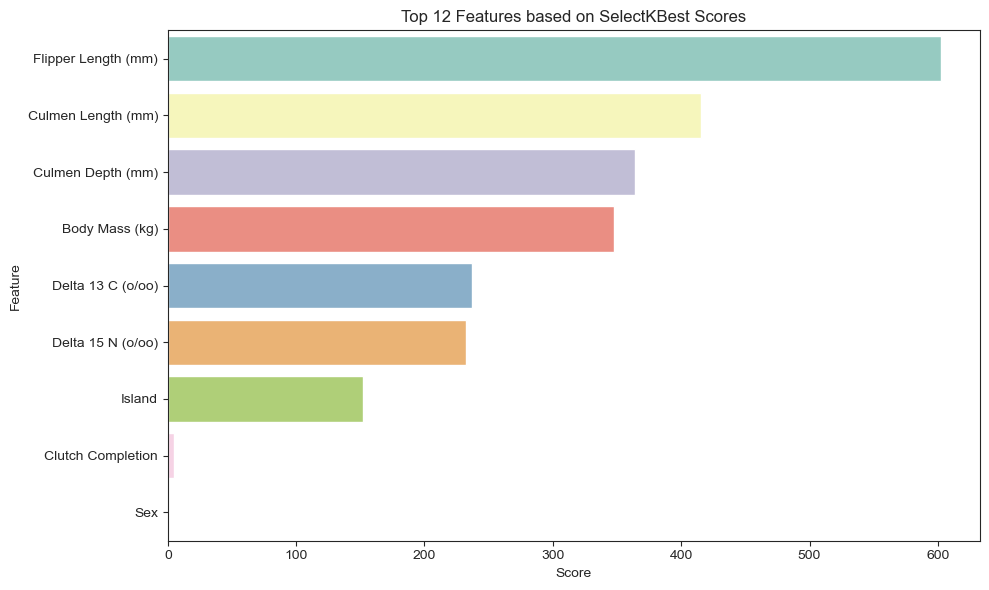

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

X = lter_encode.drop(['Species', 'Species_Code'], axis=1)
Y = lter_encode['Species']

bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X, Y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']

top_features = featureScores.nlargest(12, 'Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=top_features, palette='Set3')

plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Top 12 Features based on SelectKBest Scores')

plt.tight_layout()
plt.savefig('feature_scores.png')
plt.show()

According to the bar plot above, the two features with the lowest importance are Clutch Completion and Sex. To further confirm and compare this observation, we can examine a correlation matrix that calculates the Pearson correlation coefficient, which measures the linear relationship between variables.

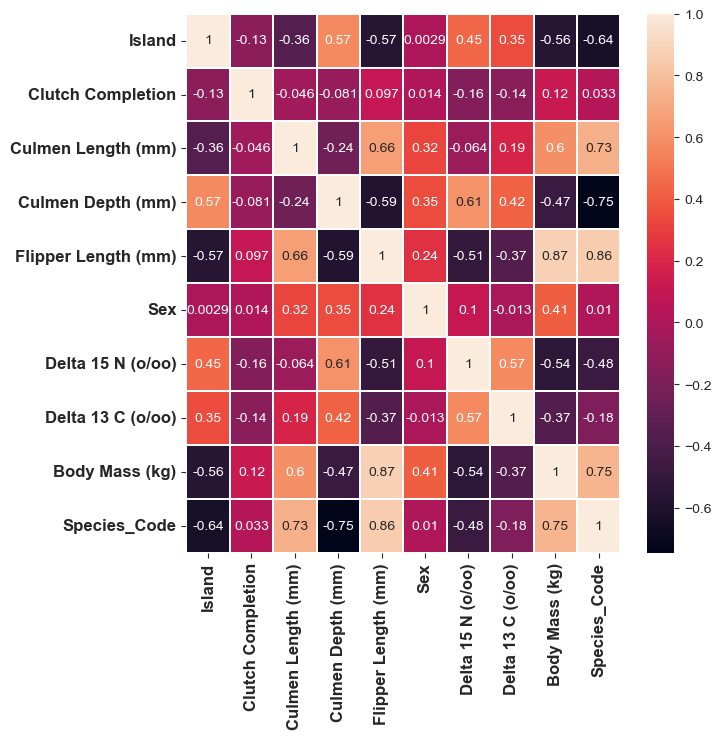

In [29]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(lter_encode.corr(),annot=True, linewidths=0.1)
plt.xticks(fontsize=12, fontweight='bold', rotation=90)
plt.yticks(fontsize=12, fontweight='bold')

plt.savefig('correlation matrix.png')
plt.show()

Once again, we can observe that both Sex and Clutch Completion exhibit almost no correlation with the species. Therefore, we will proceed to drop these features, as well as the species code, as they will no longer be needed for our analysis.

In [30]:
lter_encode_drop=lter_encode.copy()
lter_encode_drop=lter_encode_drop.drop(['Sex','Clutch Completion','Species_Code'], axis=1)
lter_encode_drop.head()

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (kg)
0,P.adeliae,2,39.100000,18.700000,181.000000,8.859733,-25.804194,3.750000
1,P.adeliae,2,39.500000,17.400000,186.000000,8.949560,-24.694540,3.800000
2,P.adeliae,2,40.300000,18.000000,195.000000,8.368210,-25.333020,3.250000
3,P.adeliae,2,38.791391,18.346358,189.953642,8.859733,-25.804194,3.700662
4,P.adeliae,2,36.700000,19.300000,193.000000,8.766510,-25.324260,3.450000


In the next step, we will transform our categorical feature, Island, into a One-Hot encoding format. This will expand the data by creating separate columns for each unique category in Island. Since Island is the only categorical feature that we will use for prediction, we will apply One-Hot encoding specifically to this feature.

In [31]:
OHE=preprocessing.OneHotEncoder()
lter_ohe=lter_encode_drop.copy()

lter_code=OHE.fit_transform(lter_ohe[['Island']]).toarray()

lter_list=list(sorted(new_lter['Island'].unique()))

lter_code=pd.DataFrame(lter_code, columns=lter_list)
lter_ohe=pd.concat([lter_code,lter_ohe], axis=1)

lter_ohe.head()

,Biscoe,Dream,Torgersen,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (kg)
0,0.0,0.0,1.0,P.adeliae,2,39.100000,18.700000,181.000000,8.859733,-25.804194,3.750000
1,0.0,0.0,1.0,P.adeliae,2,39.500000,17.400000,186.000000,8.949560,-24.694540,3.800000
2,0.0,0.0,1.0,P.adeliae,2,40.300000,18.000000,195.000000,8.368210,-25.333020,3.250000
3,0.0,0.0,1.0,P.adeliae,2,38.791391,18.346358,189.953642,8.859733,-25.804194,3.700662
4,0.0,0.0,1.0,P.adeliae,2,36.700000,19.300000,193.000000,8.766510,-25.324260,3.450000


In [32]:
lter_ohe=lter_ohe.drop(['Island'], axis=1)
lter_ohe.head()

,Biscoe,Dream,Torgersen,Species,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (kg)
0,0.0,0.0,1.0,P.adeliae,39.100000,18.700000,181.000000,8.859733,-25.804194,3.750000
1,0.0,0.0,1.0,P.adeliae,39.500000,17.400000,186.000000,8.949560,-24.694540,3.800000
2,0.0,0.0,1.0,P.adeliae,40.300000,18.000000,195.000000,8.368210,-25.333020,3.250000
3,0.0,0.0,1.0,P.adeliae,38.791391,18.346358,189.953642,8.859733,-25.804194,3.700662
4,0.0,0.0,1.0,P.adeliae,36.700000,19.300000,193.000000,8.766510,-25.324260,3.450000


In order to train a scaler model and apply it to an unknown (test) dataset, we will first split the data into training and testing sets.

In [33]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(lter_ohe.drop(['Species'], axis=1), lter_ohe['Species'],test_size=0.25, random_state=0)

print("X_train shape :",X_train.shape)
print("Y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("Y_test shape :",y_test.shape)

X_train shape : (258, 9)
Y_train shape : (258,)
X_test shape : (86, 9)
Y_test shape : (86,)


In [35]:
scaler=preprocessing.StandardScaler()

X_train_scaled=scaler.fit_transform(X_train) #Scaling and fitting the training set to a model
X_test_scaled=scaler.transform(X_test) #Transformation of testing set based off of trained scaler model

In [36]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_scaled)
print('Ratios:',pca.explained_variance_ratio_*100)#Ratio per component

Ratios: [5.20452267e+01 2.05340393e+01 1.01439880e+01 5.33733959e+00
 4.75468286e+00 3.94093867e+00 2.18820591e+00 1.05557896e+00
 1.39932590e-31]


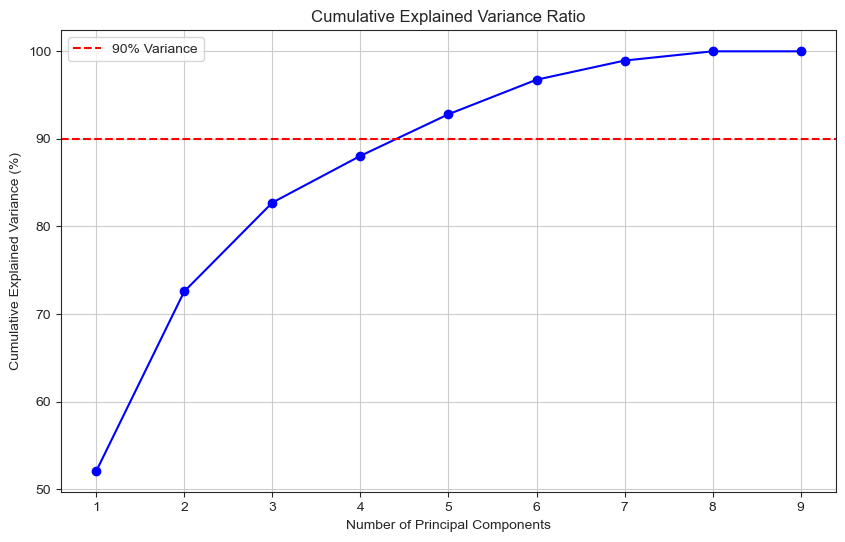

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_) * 100
component_labels = np.arange(1, len(explained_variance_ratio) + 1)

plt.figure(figsize=(10, 6))
plt.plot(component_labels, explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.axhline(y=90, color='r', linestyle='--', label='90% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance Ratio')
plt.xticks(component_labels)
plt.grid(True)
plt.legend()
plt.show()

Approximately at the 4th or 5th component, we reach an accumulated explained variance of around 90%. To ensure we capture at least 90% of the variance, we will select 5 components. Although the 4th component alone falls slightly short of 90%, including it along with the previous components will meet our criteria.